In [1]:
import nibabel as nib
import numpy as np
import os
import glob
from tqdm import tqdm

In [8]:
# Get a list of all nifti images in the data folder
brains=glob.glob('val/**/*.nii')

## Check affine on all files

In [3]:
# loop over all images
for brain in tqdm(brains):
    img = nib.load(brain)
    # get affine of the image
    affine = img.affine
    # ignore values smaller than 1E-6, by replacing them with 0
    affine[abs(affine)<1E-6]=0
    # Check if the affine uses a combination of the 3 axes
    # by countint the non-zero element in the 3x3 part of the affine matrix
    if np.count_nonzero(affine[:3,:3])!=3:
        print("Strange combination of axes in affine for image_file: "+brain)
    

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1275.61it/s]


## Code to addapt the origin !?

In [4]:
for brain in tqdm(brains):
    img = nib.load(brain)
    
    # get affine of the image
    affine = img.affine
    
    # ignore values smaller than 1E-6, by replacing them with 0
    # copy affine to a working copy
    affine_to_work=np.copy(affine)
    affine_to_work[abs(affine)<1E-6]=0
    
    # Get the voxel size
    vox=np.sqrt(np.sum(affine_to_work[:3,:3]**2))
    
    # Get the image header
    header=img.header
    # Get dimensions of the image
    shape=np.array(header.get_data_shape())
    
    # Create offset to the centre of the image
    off = np.sum(affine_to_work[:3,:3],axis=1)*(shape/2)*-1
    
    # Set the new offset on the original affine
    affine[:3,3]=off
    # Set the new affine with the updated origin 
    img.set_sform(affine)
    
    # Save image file with new affine
    img.to_filename(brain.replace('brainmask.nii','brainmask_newOrig.nii'))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.39it/s]


In [7]:
affine_to_work


array([[ -1.25454545,   0.        ,   0.        , 134.37922668],
       [  0.        ,   0.        ,   1.5363636 , -95.63263702],
       [  0.        ,  -1.32727277,   0.        ,  93.15992737],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [6]:
off

array([ 68.99999976, -84.49999809,  73.0000025 ])

In [5]:
affine

array([[-1.25454545e+00, -1.58223287e-07,  2.72912978e-15,
         6.90000000e+01],
       [ 5.57130098e-16,  8.10277117e-16,  1.53636360e+00,
        -8.45000000e+01],
       [ 4.95693276e-17, -1.32727277e+00, -4.09369499e-15,
         7.30000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

## Register brains to MNI space

In [9]:
from os.path import join as pjoin
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

In [10]:
files, folder = fetch_stanford_hardi()
static_data, static_affine = load_nifti(pjoin(folder, 'HARDI150.nii.gz'))
static = np.squeeze(static_data)[..., 0]
static_grid2world = static_affine

In [22]:
files, folder = fetch_syn_data()
moving_data, moving_affine = load_nifti(pjoin(brains[199]))
moving = moving_data
moving_grid2world = moving_affine

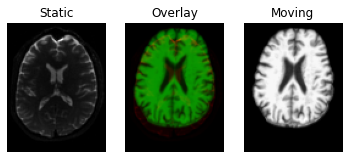

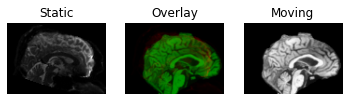

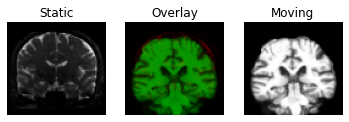

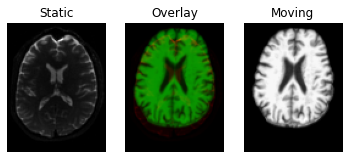

In [23]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

In [24]:
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)

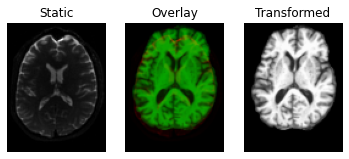

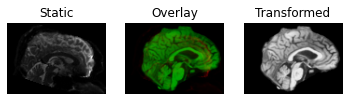

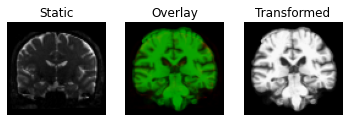

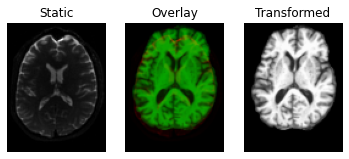

In [25]:
transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")

In [26]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

level_iters = [10000, 1000, 100]

sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)


Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


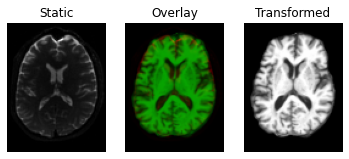

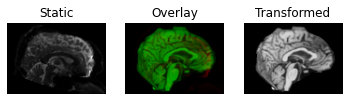

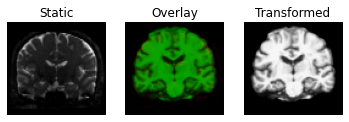

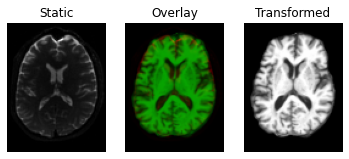

In [27]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

In [28]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


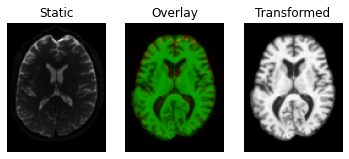

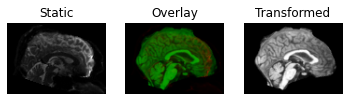

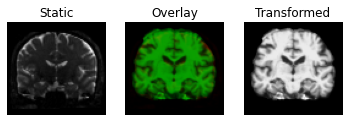

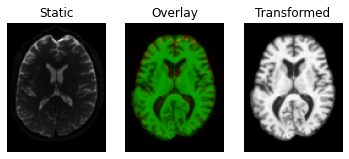

In [29]:
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_rigid_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_rigid_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_rigid_2.png")

In [30]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


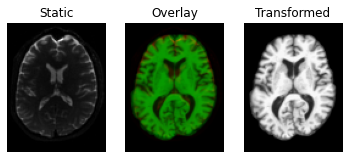

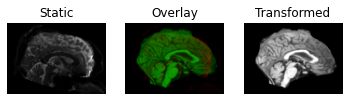

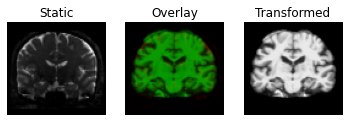

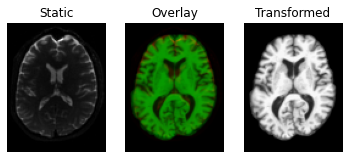

In [31]:
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")
